# Download do Dataset

In [1]:
#https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

In [2]:
#%%sh
#pip install kaggle

In [3]:
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#!kaggle datasets download -d blastchar/telco-customer-churn

# Importação de Bilbiotecas

In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import early_stopping

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

# Split Conjunto Treino/Teste

In [17]:
alvo = 'Churn'
df_tot = pd.read_csv('telco-customer-churn.zip', dtype = {'SeniorCitizen': str})
df_tot[alvo] = df_tot[alvo].map({'Yes': 1, 'No': 0})
df_tot.loc[df_tot['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_tot['TotalCharges'] = df_tot['TotalCharges'].astype(float)

In [18]:
df_teste = df_tot.sample(frac = 0.25, random_state = 42)
df = df_tot[~df_tot.index.isin(df_teste.index)]

In [19]:
display(display(df_tot[['Partner', alvo]].groupby('Partner').agg(['count', 'mean'])))

Churn          
        count      mean
Partner                
No       3641  0.329580
Yes      3402  0.196649

None

# Tratamento de Features

In [20]:
colunas_id = ['customerID']
features_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
features_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [21]:
dict_dummies = {}
for f in features_categoricas:
    lista_dummies = list(df[f].value_counts().index[:-1])
    dict_dummies[f] = lista_dummies

for k,v in dict_dummies.items():
    for value in v:
        df[k + '_' + value] = (df[k] == value).astype(int)
        df_teste[k + '_' + value] = (df_teste[k] == value).astype(int)
    df.drop(k, axis = 1, inplace = True)
    df_teste.drop(k, axis = 1, inplace = True)
df.columns = [c.replace(' ', '_') for c in df.columns]
df_teste.columns = [c.replace(' ', '_') for c in df_teste.columns]

In [22]:
features = ['tenure', 'MonthlyCharges', 'TotalCharges',
            'gender_Male', 'SeniorCitizen_0', 'Partner_No', 'Dependents_No',
            'PhoneService_Yes', 'PaperlessBilling_Yes', 'MultipleLines_No',
            'MultipleLines_Yes', 'InternetService_Fiber_optic',
            'InternetService_DSL', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
            'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
            'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
            'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
            'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_Two_year',
            'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check',
            'PaymentMethod_Bank_transfer_(automatic)']

# Treinamento do Modelo

In [23]:
#Simula treinar com uma amostra da base
df_train = df.sample(frac = 1.0, random_state = 42)

In [24]:
X = df_train[features]
y = df_train[alvo].astype(int)

Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[2611]	training's binary_logloss: 0.40329	valid_1's binary_logloss: 0.41712


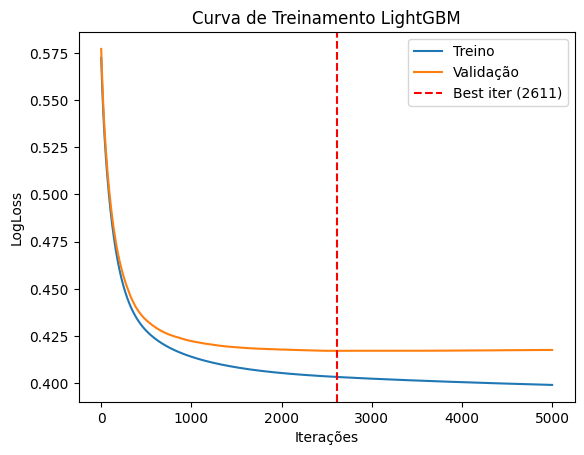

Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[3173]	training's binary_logloss: 0.416526	valid_1's binary_logloss: 0.4001


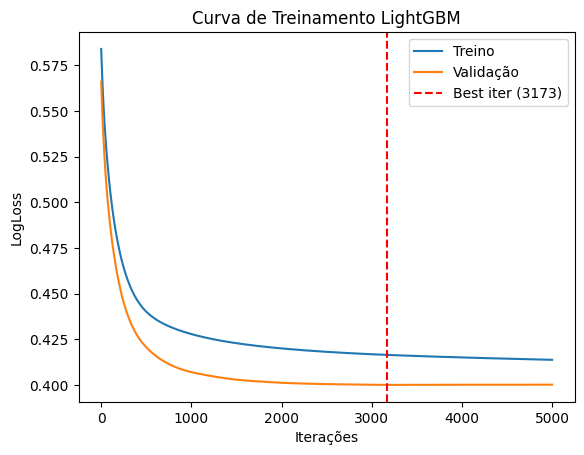

Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[4824]	training's binary_logloss: 0.391814	valid_1's binary_logloss: 0.421967


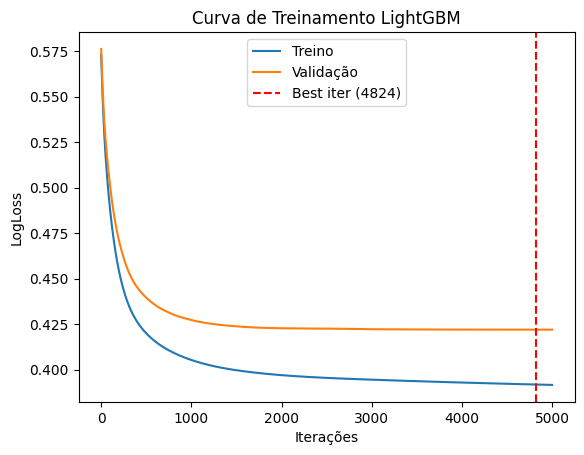

Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[2124]	training's binary_logloss: 0.38921	valid_1's binary_logloss: 0.42576


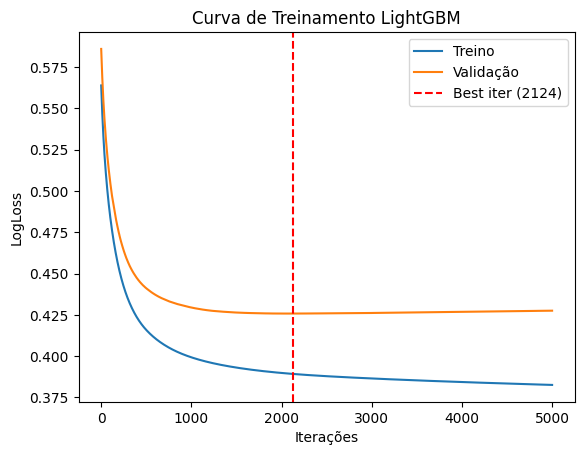


AUC:
0.8522603089162792
KS:
0.5438335046248716


In [61]:
lista_modelos = []
for i in range(0, 4):
    df_t = df_train.sample(frac = 0.5, random_state = i)
    df_v = df_train[~df_train.index.isin(df_t.index)]
    X_t = df_t[features]
    y_t = df_t[alvo].astype(int)
    X_v = df_v[features]
    y_v = df_v[alvo].astype(int)

    lgbm_clf = LGBMClassifier(
                            objective = 'binary',
                            boosting_type = 'gbdt',
                            force_row_wise = True,
                            random_state = 42,
                            n_jobs = -1,
                            verbose = -1,

                            max_depth = 1, #Quando mais rasa as árvores menor (mais simples)
                            learning_rate = 0.01, #Quanto menor o learning_rate menor (menos incremento no modelo por iteração)
                            n_estimators = 5000 #Vamos forçar até o limite do overfitting
                            )

    lgbm_clf.fit(
                X_t, y_t,
                eval_set = [(X_t, y_t), (X_v, y_v)],
                callbacks = [early_stopping(stopping_rounds = 3000, verbose = True)]
                )

    results = lgbm_clf.evals_result_
    plt.plot(results["training"]["binary_logloss"], label="Treino")
    plt.plot(results["valid_1"]["binary_logloss"], label="Validação")
    plt.axvline(lgbm_clf.best_iteration_, color="r", linestyle="--", label=f"Best iter ({lgbm_clf.best_iteration_})")
    plt.xlabel("Iterações")
    plt.ylabel("LogLoss")
    plt.title("Curva de Treinamento LightGBM")
    plt.legend()
    plt.show()

    lista_modelos.append(lgbm_clf)

print('')

probs = np.mean([m.predict_proba(X)[:, 1] for m in lista_modelos], axis = 0)
print('AUC:')
print(roc_auc_score(y, probs))
print('KS:')
print(ks_2samp(probs[y == 0], probs[y == 1]).statistic)

# Avaliação no Conjunto de Teste

In [62]:
X_teste = df_teste[features]
y_teste = df_teste[alvo]

In [63]:
probs_teste = np.mean([m.predict_proba(X_teste)[:, 1] for m in lista_modelos], axis = 0)
print('AUC:')
print(roc_auc_score(y_teste, probs_teste))
print('KS:')
print(ks_2samp(probs_teste[y_teste == 0], probs_teste[y_teste == 1]).statistic)

AUC:
0.8626892674871922
KS:
0.583741804787014


# Análise em Subconjuntos

In [64]:
def analise_subconjunto(probs, y, mask):
    print('AUC:')
    print(roc_auc_score(y[mask], probs[mask]))
    print('KS:')
    print(ks_2samp(probs[(y == 0) & mask], probs[(y == 1) & mask]).statistic)

In [65]:
print(50*'=')
print('Avaliação Solteiros:')
print()
mask_partner_no = (df['Partner_No'] == 1).values
analise_subconjunto(probs, y, mask_partner_no)

print('')
print(50*'=')
print('Avaliação Casados:')
print()
mask_partner_yes = (df['Partner_No'] == 0).values
analise_subconjunto(probs, y, mask_partner_yes)

Avaliação Solteiros:

AUC:
0.8513826707153451
KS:
0.5403114186851211

Avaliação Casados:

AUC:
0.8533172819689674
KS:
0.5490217972875521


In [66]:
print(50*'=')
print('Avaliação Solteiros:')
print()
mask_partner_no = (df_teste['Partner_No'] == 1).values
analise_subconjunto(probs_teste, y_teste, mask_partner_no)

print('')
print(50*'=')
print('Avaliação Casados:')
print()
mask_partner_yes = (df_teste['Partner_No'] == 0).values
analise_subconjunto(probs_teste, y_teste, mask_partner_yes)

Avaliação Solteiros:

AUC:
0.8419420664147815
KS:
0.5515009485548488

Avaliação Casados:

AUC:
0.8731623109868019
KS:
0.6289397779914343
